Data URL from Kaggle: https://www.kaggle.com/datasets/alincijov/self-driving-cars?resource=downloadLinks 

In [ ]:
import keras
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from keras.regularizers import L2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# This is the module with image preprocessing utilities
from tensorflow.keras import utils as image
from keras.models import load_model
from keras.utils import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler
from PIL import Image

2023-07-31 16:04:26.975441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading the Data:

In [ ]:
labels_train = pd.read_csv('data/labels_train.csv')

In [ ]:
labels_val = pd.read_csv('data/labels_val.csv')

In [5]:
type(labels_train)

pandas.core.frame.DataFrame

In [6]:
labels_train.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [7]:
labels_val.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1


# Pre-Processing:

In [12]:
label_to_index = {'car':1, 'truck':2, 'pedestrian':3, 'bicyclist':4, 'light':5}
index_to_label = {v:k for k, v in label_to_index.items()}

The 2 code cells below crop images and extract out different objects using xmax, xmin, ymax & ymin values from labels dataframes for train & validation labels in labels_train & labels_validation.

In [ ]:
# Train Labels:

crop_data_train = False
if crop_data_train:
    img_idx = 0
    for index, row in labels_train.iterrows():
        try:
            # Opens image and saves it using the PIL package
            orig_img = Image.open(f"data/images/{row['frame']}")

            # Cropping
            bound_box = (row['xmin'], row['ymin'], 
                         row['xmax'], row['ymax'])

            cropped_img = orig_img.crop(bound_box)

            dest_path = f"train_data_cropped_new/{index_to_label[row['class_id']]}"

            file_name = f'{img_idx}.png'
            cropped_img.save(os.path.join(dest_path, file_name), 'png')

            img_idx += 1
        
        # Catches if a crop extends past an image and warns the user, but code still keeps running
        except SystemError as e:
            print(e)


In [ ]:
# Validation Labels:

crop_data_val = False
if crop_data_val:
    img_idx = 0
    for index, row in labels_val.iterrows():

        orig_img = Image.open(f"data/images/{row['frame']}")
        
        bound_box = (row['xmin'], row['ymin'], 
                     row['xmax'], row['ymax'])
        
        cropped_img = orig_img.crop(bound_box)
        
        dest_path = f"val_data_cropped_new/{index_to_label[row['class_id']]}"
        
        file_name = f'{img_idx}.png'
        cropped_img.save(os.path.join(dest_path, file_name), 'png')
        
        img_idx += 1

# Exploratory Data Analysis:

#### Determining Image Sizes:

In [ ]:
# Read in cropped images for train and validation data:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://notebook.community/tensorflow/docs-l10n/site/en-snapshot/tutorials/load_data/images

class_types = ["car", "truck", "pedestrian", "bicyclist", "light"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='~/data/train_data_cropped_new',
    image_size=(32, 32),
    class_names = class_types)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='~/data/val_data_cropped_new',
    image_size=(32, 32),
    class_names = class_types)
  

Found 132404 files belonging to 5 classes.


2023-07-31 16:05:37.430815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 32699 files belonging to 5 classes.


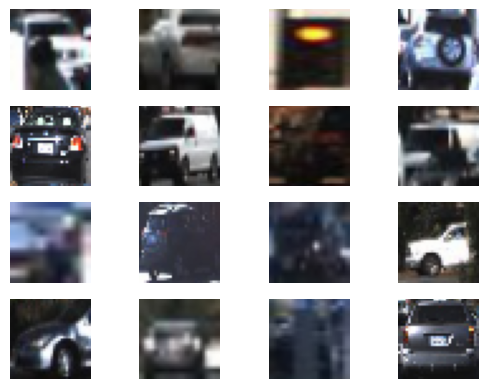

In [ ]:
# The algorithm can still interpret some of these images even ones that are blurry
fig, axs = plt.subplots(4, 4)
for images, label in train_ds:
    for i in range(4):
        for j in range(4):
            img_id = 4*i+j
            axs[i,j].imshow(tf.cast(images[img_id], tf.int16))
            axs[i,j].axis('off')
    break


#### Count the Number of Images in Each Class:

In [ ]:
directories = [os.path.join('train_data_cropped_new', c) for c in class_types]
class_counts = []
for dirc in directories:
    class_count = len(os.listdir(dirc))
    class_counts.append(class_count)
    print(f'{dirc} has {class_count} files')
    

train_data_cropped_new/car has 101312 files
train_data_cropped_new/truck has 6313 files
train_data_cropped_new/pedestrian has 10637 files
train_data_cropped_new/bicyclist has 1442 files
train_data_cropped_new/light has 12700 files


#### Redistributing Imbalanced Classes:

class_weight assigns the weights of different classes based on their prevalence and is passed into the model.fit() method as an argument

In [27]:
class_weight = {i:max(class_counts)/x for i,x in enumerate(class_counts)}
print(class_weight)

{0: 1.0, 1: 16.048154601615714, 2: 9.524489987778509, 3: 70.25797503467406, 4: 7.977322834645669}


This changes learing rates by approriately multiplying the learning rate to diminish the effect of overrepresented classes such as cars. Cars had about 10 times more images than the other 4 classes. 

# Neural Network Models:

#### Unregularized Model:

In [49]:
redo_model_1 = False

In [ ]:
if redo_model_1:
    model = models.Sequential()
    
    # input shape is 32 x 32 x 3 since images were made to 32 x 32 in the beginning of this code
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))


In [51]:
if redo_model_1:
    model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, epochs=100, validation_data=val_ds,
              class_weight = class_weight)


In [112]:
if redo_model_1:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy\nof Unregularized, Overfit Neural Network')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('model_overfit_train_val_accs.png', bbox_inches='tight')
    plt.figure()

    plt.plot(epochs, loss, 'bo', color='green', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss\nof Unregularized, Overfit Neural Network')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('model_overfit_train_val_loss.png', bbox_inches='tight')
    plt.show()


### Regularized Models:

#### Only Early Stopping:

In [52]:
redo_model_2 = False

In [ ]:
if redo_model_2:
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))


In [34]:
if redo_model_2:
    patience = 5

    early_stopping_cb = EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=patience,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=0
    )

In [35]:
if redo_model_2:    
    model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, epochs=20, validation_data=val_ds,
              class_weight = class_weight, callbacks=[early_stopping_cb])

Epoch 1/20
4138/4138 [==============================] - 206s 50ms/step - loss: 4.0302 - accuracy: 0.6102 - val_loss: 0.8292 - val_accuracy: 0.7033
Epoch 2/20
4138/4138 [==============================] - 205s 50ms/step - loss: 2.7555 - accuracy: 0.7045 - val_loss: 0.8297 - val_accuracy: 0.6984
Epoch 3/20
4138/4138 [==============================] - 205s 50ms/step - loss: 2.5116 - accuracy: 0.7281 - val_loss: 0.6855 - val_accuracy: 0.7616
Epoch 4/20
4138/4138 [==============================] - 205s 49ms/step - loss: 2.2821 - accuracy: 0.7456 - val_loss: 0.6628 - val_accuracy: 0.7670
Epoch 5/20
4138/4138 [==============================] - 196s 47ms/step - loss: 2.2082 - accuracy: 0.7554 - val_loss: 0.7351 - val_accuracy: 0.7392
Epoch 6/20
4138/4138 [==============================] - 211s 51ms/step - loss: 2.1968 - accuracy: 0.7617 - val_loss: 0.5638 - val_accuracy: 0.8115
Epoch 7/20
4138/4138 [==============================] - 212s 51ms/step - loss: 2.0106 - accuracy: 0.7751 - val_loss: 0

#### Validation Accuracy:

In [114]:
results = model.evaluate(val_ds)
results

1022/1022 [==============================] - 10s 10ms/step - loss: 0.5638 - accuracy: 0.8115


[0.5637869238853455, 0.8114621043205261]

results[0] is loss, and results[1] is accuracy

/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2718726165.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2718726165.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', color='green', label='Training loss')


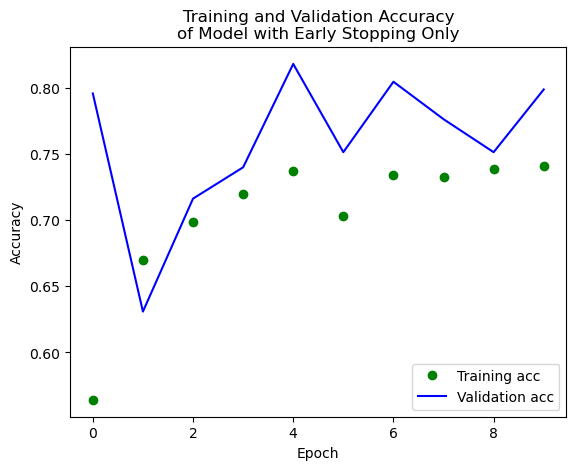

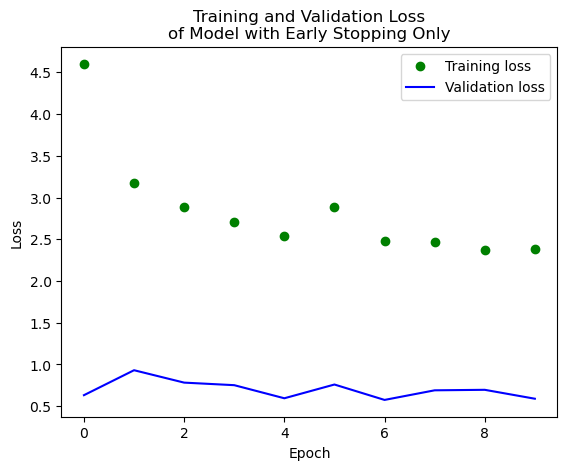

In [116]:
if redo_model_2:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy\nof Model with Early Stopping Only')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('Ear_Stop_Only_Accs.png', bbox_inches='tight')
    plt.figure()

    plt.plot(epochs, loss, 'bo', color='green', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss\nof Model with Early Stopping Only')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('Ear_Stop_Only_Loss.png', bbox_inches='tight')
    plt.show()


In [37]:
if redo_model_2:
    model.save('model_ear_stop_only.h5')

#### Early Stopping and L2 Norm:

In [53]:
redo_model_3 = False

In [ ]:
if redo_model_3:
    val_accs = []
    train_accs = []

    lam_vals = [10**(-n/2) for n in range(5)]

    for lam in lam_vals:
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu',
                                input_shape=(32, 32, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(lam)))
        model.add(layers.Dense(5, activation='softmax'))

        patience = 5

        early_stopping_cb = EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=patience,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=0
        )

        model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

        history = model.fit(train_ds, 
                            epochs=20, 
                            validation_data=val_ds,
                            class_weight = class_weight,
                            verbose=0,
                            callbacks=[early_stopping_cb])

        v_ac = max(history.history['val_accuracy'])
        tr_ac = max(history.history['accuracy'])

        val_accs.append(v_ac)

        train_accs.append(tr_ac)
    

In [42]:
val_accs

[0.8524419665336609,
 0.842839241027832,
 0.841096043586731,
 0.8534817695617676,
 0.8528395295143127]

In [43]:
train_accs

[0.8230718374252319,
 0.7976722717285156,
 0.8261306285858154,
 0.8137291669845581,
 0.8305111527442932]

In [44]:
max(val_accs)

0.8534817695617676

In [47]:
best_lam = lam_vals[val_accs.index(max(val_accs))]
best_lam

0.03162277660168379

#### Model with Best Lambda for L2 Regularization and Early Stopping:

In [124]:
if redo_model_3:
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', 
                           kernel_regularizer=L2(best_lam)))
    model.add(layers.Dense(5, activation='softmax'))

    patience = 5

    early_stopping_cb = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0,
        patience=patience,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    )

    model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, 
                        epochs=20, 
                        validation_data=val_ds,
                        class_weight = class_weight,
                        callbacks=[early_stopping_cb])


Epoch 1/20
4138/4138 [==============================] - 246s 59ms/step - loss: 13.0846 - accuracy: 0.5435 - val_loss: 1.8781 - val_accuracy: 0.6613
Epoch 2/20
4138/4138 [==============================] - 241s 58ms/step - loss: 3.8269 - accuracy: 0.6706 - val_loss: 1.3736 - val_accuracy: 0.7943
Epoch 3/20
4138/4138 [==============================] - 238s 58ms/step - loss: 3.2402 - accuracy: 0.7236 - val_loss: 1.2058 - val_accuracy: 0.7923
Epoch 4/20
4138/4138 [==============================] - 238s 57ms/step - loss: 2.9835 - accuracy: 0.7443 - val_loss: 1.3630 - val_accuracy: 0.7998
Epoch 5/20
4138/4138 [==============================] - 238s 58ms/step - loss: 2.9430 - accuracy: 0.7521 - val_loss: 1.0272 - val_accuracy: 0.8332
Epoch 6/20
4138/4138 [==============================] - 239s 58ms/step - loss: 2.6092 - accuracy: 0.7748 - val_loss: 1.0929 - val_accuracy: 0.8037
Epoch 7/20
4138/4138 [==============================] - 238s 58ms/step - loss: 2.5345 - accuracy: 0.7790 - val_loss: 

In [125]:
if redo_model_3:
    model.save('model_ear_stop_and_L2.h5')

#### Validation Accuracy:

In [126]:
results = model.evaluate(val_ds)
results

1022/1022 [==============================] - 9s 9ms/step - loss: 1.0272 - accuracy: 0.8332


[1.027228593826294, 0.8332365155220032]

/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2201704933.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2201704933.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', color='green', label='Training loss')


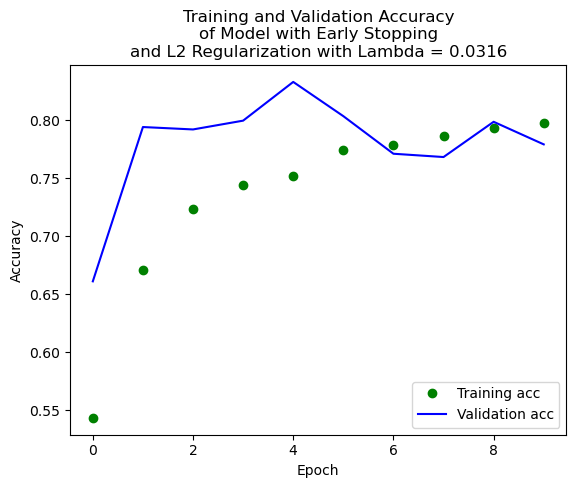

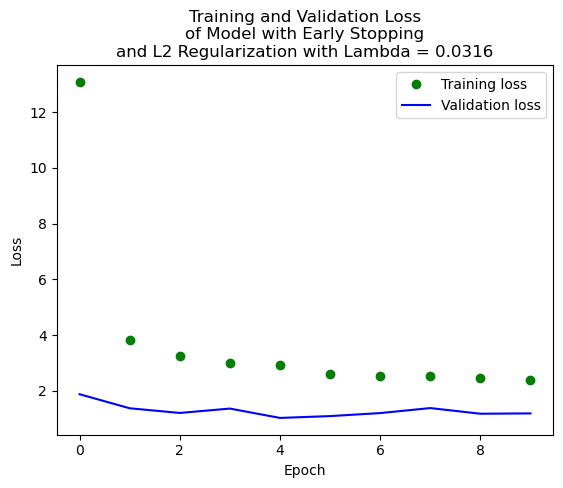

In [129]:
if redo_model_3:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy\nof Model with Early Stopping\nand L2 Regularization with Lambda = 0.0316')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.savefig('Ear_Stop_and_L2_Accs.png', bbox_inches='tight')
    plt.figure()

    plt.plot(epochs, loss, 'bo', color='green', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss\nof Model with Early Stopping\nand L2 Regularization with Lambda = 0.0316')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('Ear_Stop_and_L2_Loss.png', bbox_inches='tight')
    plt.show()


#### Model with Early Stopping and Dropout

In [54]:
redo_model_4 = False

In [130]:
dropout_vals = np.linspace(0.2,0.4,3)
dropout_vals

array([0.2, 0.3, 0.4])

In [ ]:
if redo_model_4:

    val_accs = []
    train_accs = []

    for dp in dropout_vals:
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu',
                                input_shape=(32, 32, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dp))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dp))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dense(5, activation='softmax'))
        
        # cannot put dropout after the output layer since it zeroes out some of the output
    
        patience = 5

        early_stopping_cb = EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=patience,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=0
        )

        model.compile(optimizer='Adam', 
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train_ds, 
                            epochs=20, 
                            validation_data=val_ds,
                            class_weight = class_weight,
                            verbose=0,
                            callbacks=[early_stopping_cb])

        v_ac = max(history.history['val_accuracy'])
        tr_ac = max(history.history['accuracy'])

        val_accs.append(v_ac)

        train_accs.append(tr_ac)
        
        print(f'Dropout Rate: {dp} model done')

        

Dropout Rate: 0.2 model done
Dropout Rate: 0.30000000000000004 model done
Dropout Rate: 0.4 model done


/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2633021875.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(dropout_vals, val_accs, 'b', label='validation accuracies',color="blue")
/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/2633021875.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(dropout_vals, train_accs, 'b', label='train accuracies',color="red")


<Figure size 640x480 with 0 Axes>

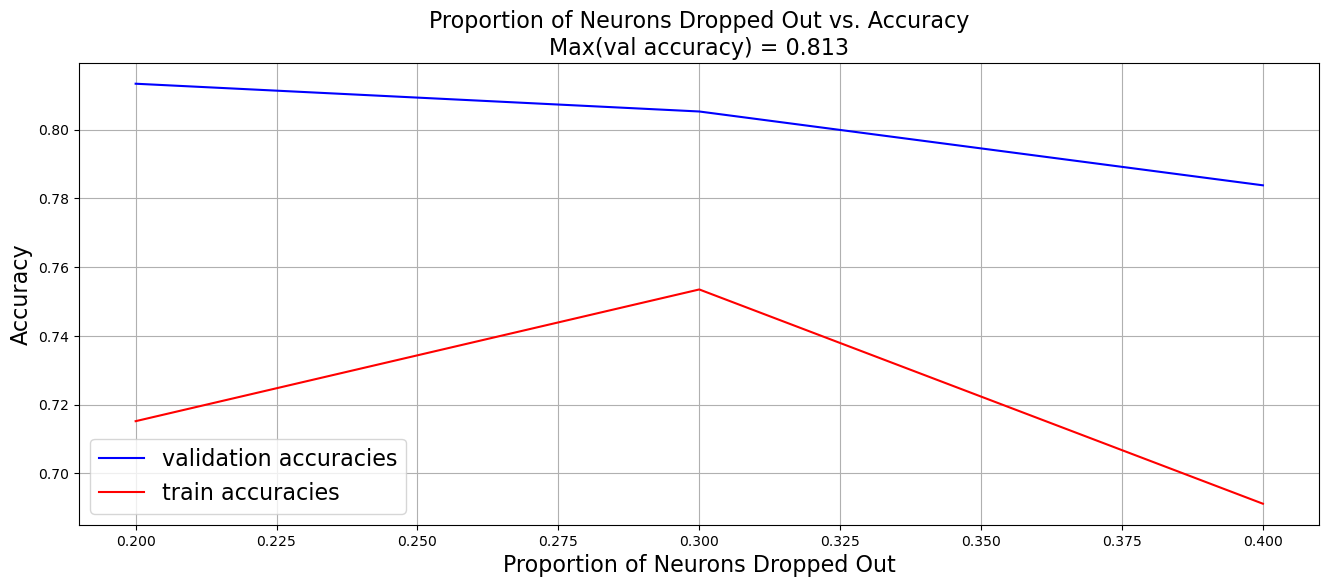

In [86]:
if redo_model_4:

    plt.clf()

    n_drop = len(dropout_vals)

    plt.figure(figsize=(16,6))

    plt.plot(dropout_vals, val_accs, 'b', label='validation accuracies',color="blue")
    plt.plot(dropout_vals, train_accs, 'b', label='train accuracies',color="red")

    plt.title('Proportion of Neurons Dropped Out vs. Accuracy\nMax(val accuracy) = ' + str(round(max(val_accs),3)),fontsize=16)
    plt.xlabel('Proportion of Neurons Dropped Out',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.grid(True)
    plt.legend(loc = 'lower left',fontsize=16)
    
    plt.savefig('Diff_Dropout_Acc.png', bbox_inches='tight')
    plt.show()

In [87]:
val_accs

[0.8133276104927063, 0.8052539825439453, 0.7837854623794556]

In [88]:
train_accs

[0.7152049541473389, 0.7535044550895691, 0.691202700138092]

In [89]:
max(val_accs)

0.8133276104927063

In [91]:
best_dp = dropout_vals[val_accs.index(max(val_accs))]
best_dp

0.2

#### Model with Best Dropout Rate and Early Stopping:

In [ ]:
if redo_model_4:

    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(best_dp))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(best_dp))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    patience = 5

    early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                      min_delta=0,
                                      patience=patience,
                                      verbose=0,
                                      mode='auto',
                                      baseline=None,
                                      restore_best_weights=True,
                                      start_from_epoch=0)

    model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
                        epochs=20, 
                        validation_data=val_ds,
                        class_weight = class_weight,
                        callbacks=[early_stopping_cb])


Epoch 1/20
4138/4138 [==============================] - 263s 63ms/step - loss: 4.4364 - accuracy: 0.5591 - val_loss: 0.7644 - val_accuracy: 0.7361
Epoch 2/20
4138/4138 [==============================] - 264s 64ms/step - loss: 3.1404 - accuracy: 0.6730 - val_loss: 0.8223 - val_accuracy: 0.7134
Epoch 3/20
4138/4138 [==============================] - 260s 63ms/step - loss: 2.8007 - accuracy: 0.7076 - val_loss: 0.6775 - val_accuracy: 0.7769
Epoch 4/20
4138/4138 [==============================] - 275s 66ms/step - loss: 2.6142 - accuracy: 0.7213 - val_loss: 0.7324 - val_accuracy: 0.7577
Epoch 5/20
4138/4138 [==============================] - 234s 57ms/step - loss: 2.5876 - accuracy: 0.7234 - val_loss: 0.6647 - val_accuracy: 0.7744
Epoch 6/20
4138/4138 [==============================] - 276s 67ms/step - loss: 2.5755 - accuracy: 0.7272 - val_loss: 0.6987 - val_accuracy: 0.7569
Epoch 7/20
4138/4138 [==============================] - 263s 63ms/step - loss: 2.4899 - accuracy: 0.7360 - val_loss: 0

In [133]:
if redo_model_4:
    model.save('model_ear_stop_and_drop.h5')

#### Validation Accuracy:

In [134]:
results = model.evaluate(val_ds)
results

1022/1022 [==============================] - 10s 10ms/step - loss: 0.6817 - accuracy: 0.7746


[0.6816835403442383, 0.7746414542198181]

/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/1467508421.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
/var/folders/_p/wr8rlmq53xlb17pvs7p0hsfm0000gn/T/ipykernel_1699/1467508421.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', color='green', label='Training loss')


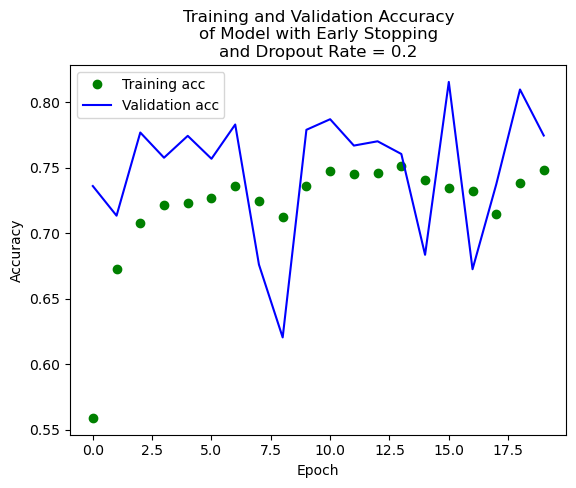

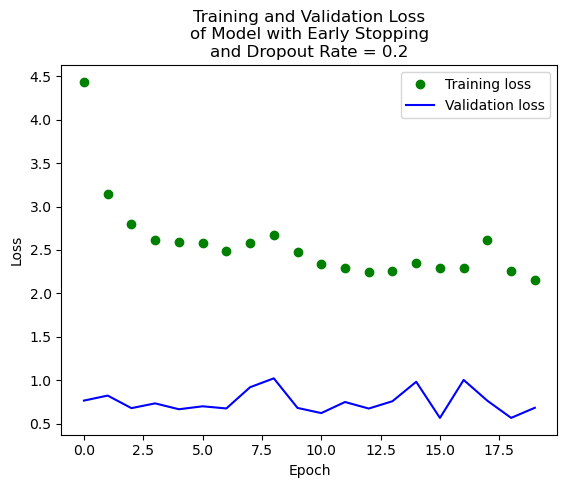

In [135]:
if redo_model_4:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', color='green', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy\nof Model with Early Stopping\nand Dropout Rate = 0.2')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('Ear_Stop_and_Drop_Accs.png', bbox_inches='tight')
    plt.figure()

    plt.plot(epochs, loss, 'bo', color='green', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss\nof Model with Early Stopping\nand Dropout Rate = 0.2')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('Ear_Stop_and_Drop_Loss.png', bbox_inches='tight')
    plt.show()


# Calculating Predictions Using the Highest Accuracy Model:

In [22]:
best_model = load_model('model_ear_stop_and_L2.h5')

In [ ]:
val_disp_imgs_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='~/data/val_imgs_to_disp_and_pred',
    image_size=(32, 32),
    class_names = class_types,
    shuffle=False)
  

Found 15 files belonging to 5 classes.


In [45]:
pred_probs = best_model.predict(val_disp_imgs_ds)

1/1 [==============================] - 0s 26ms/step


In [43]:
pred_classes = np.argmax(pred_probs, axis=1)
pred_classes

array([3, 3, 0, 0, 0, 0, 4, 4, 4, 2, 2, 2, 1, 1, 1])

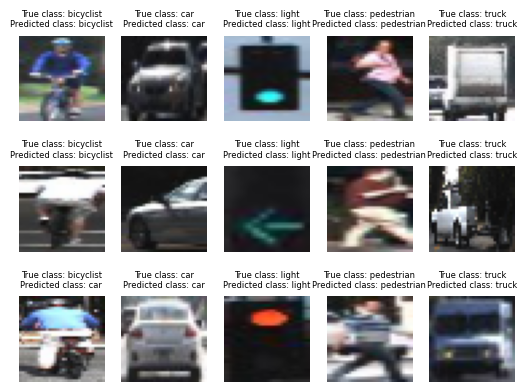

In [ ]:
fig, axs = plt.subplots(3, 5)

for images, labels in val_disp_imgs_ds:
    for i, img in enumerate(images):
        pred_class = class_types[pred_classes[i]]
        true_class = class_types[int(labels[i])]
        
        # index of [i%3, i//3] fills in the grid so that images of the same class type are placed in the same column
        axs[i%3, i//3].imshow(tf.cast(img, tf.int32))
        axs[i%3, i//3].set_title(f'True class: {true_class}\nPredicted class: {pred_class}', 
                                 fontsize=6)
        axs[i%3, i//3].axis('off')   
    break